# Large scale text analysis with deep learning (3 points)

In this assignment, you will develop a deep learning model to predict salaries based on resumes (credits to to [Oleg Vasilev](https://github.com/Omrigan/)). While we will begin this project during our seminar class, it will require additional effort on your part to finalize and submit it as homework.

Following this, there is a supplementary task in another notebook titled homework_part2.ipynb. In this task, you are expected to conduct a more extensive study. This will involve testing various architectures to optimize prediction accuracy.

To secure full marks for this assignment, ensure a consistent training process with an MSE loss falling below 0.10. If necessary, feel free to experiment with different parameters and model architectures. If you achieve the desired results in the homework_part2.ipynb, you can either replicate your solution here or reference it explicitly in the comments when you submit.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### About the challenge
For starters, let's download and unpack the data from 
1) Yandex-disk [yadisk url](https://yadi.sk/d/vVEOWPFY3NruT7), or
2) the Kaggle ompetition [page](https://www.kaggle.com/c/job-salary-prediction/data) (pick `Train_rev1.*`).

In [2]:
data = pd.read_csv("./Train_rev1.zip", compression='zip', index_col=None)
data.shape

(244768, 12)

In [3]:
data.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


One problem with salary prediction is that it's oddly distributed: there are many people who are paid standard salaries and a few that get tons o money. The distribution is fat-tailed on the right side, which is inconvenient for MSE minimization.

There are several techniques to combat this: using a different loss function, predicting log-target instead of raw target or even replacing targets with their percentiles among all salaries in the training set. We gonna use logarithm for now.

_You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description)._

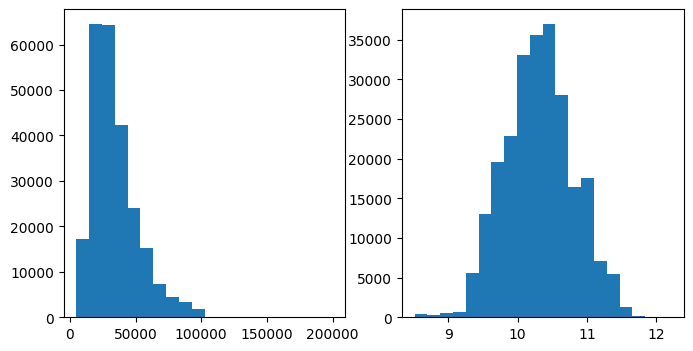

In [4]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20)

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20);

Our task is to predict one number, __Log1pSalary__.

To do so, our model can access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.

In [5]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
32882,68101541,Pastry Chef Luxury Hotel ****AA Rosettes Li...,We are currently recruiting for a number of st...,"Reading, Berkshire, UK, Berkshire",Reading,NaN,NaN,Cherryred Recruitment,Hospitality & Catering Jobs,"Upto 20,000 per annum PLUS Live-in and Overtime!",20000,jobs.catererandhotelkeeper.com,9.903538
160644,71186503,Senior Mechanical Design Engineer Energy,Senior Mechanical Design Engineer Energy Sala...,UK,UK,NaN,permanent,Green Recruitment Company,"Energy, Oil & Gas Jobs",Up to 55K + benefits,55000,totaljobs.com,10.915107
105740,69585243,C ASPNet Web Applications Developer Hull Up ...,C ASP.Net Web Applications Developer Hull Up...,Kingston Upon Hull,UK,NaN,permanent,NaN,IT Jobs,20000 - 30000 per annum + Benefits,25000,theitjobboard.co.uk,10.126671


### Preprocessing text data

Just like last week, applying NLP to a problem begins from tokenization: splitting raw text into sequences of tokens (words, punctuation, etc).

__Your task__ is to lowercase and tokenize all texts under `Title` and `FullDescription` columns. Store the tokenized data as a __space-separated__ string of tokens for performance reasons.

It's okay to use nltk tokenizers. Assertions were designed for WordPunctTokenizer, slight deviations are okay.

In [6]:
print("Raw text:")
print(data["FullDescription"][2::100000])

Raw text:
2         Mathematical Modeller / Simulation Analyst / O...
100002    A successful and high achieving specialist sch...
200002    Web Designer  HTML, CSS, JavaScript, Photoshop...
Name: FullDescription, dtype: object


In [7]:
data["Title"] = data["Title"].fillna("NaN")

In [8]:
import nltk
#TODO YOUR CODE HERE

tokenizer = nltk.tokenize.WordPunctTokenizer()
data["FullDescription"] = [" ".join(tokenizer.tokenize(text)).lower() for text in data["FullDescription"]]
data["Title"] = [" ".join(tokenizer.tokenize(text)).lower() for text in data["Title"]]

Now we can assume that our text is a space-separated list of tokens:

In [9]:
print("Tokenized:")
print(data["FullDescription"][2::100000])
assert data["FullDescription"][2][:50] == 'mathematical modeller / simulation analyst / opera'
assert data["Title"][54321] == 'international digital account manager ( german )'

Tokenized:
2         mathematical modeller / simulation analyst / o...
100002    a successful and high achieving specialist sch...
200002    web designer html , css , javascript , photosh...
Name: FullDescription, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's count how many times is each word present in the data so that we can build a "white list" of known words.

In [10]:
from collections import Counter
token_counts = Counter()

def count_words(data_coll):
    for text in data_coll.values:
        for word in text.split():
            token_counts[word] += 1
            
# Count how many times does each token occur in both "Title" and "FullDescription" in total
#TODO <YOUR CODE>

count_words(data["FullDescription"])
count_words(data["Title"])

In [11]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('improvemen', 1)
('techniciancivil', 1)
('mlnlycke', 1)
Correct!


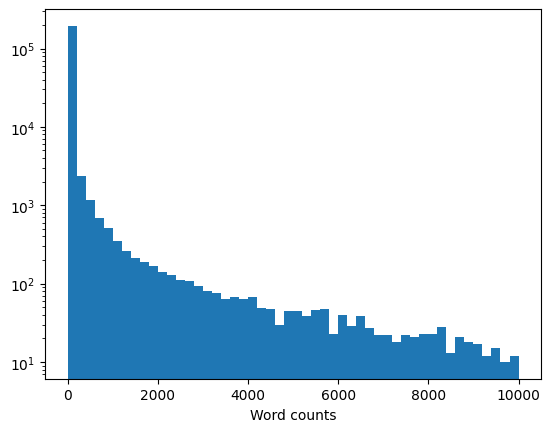

In [12]:
# Let's see how many words are there for each count
plt.hist(list(token_counts.values()), range=(0, 10**4), bins=50, log=True)
plt.xlabel("Word counts");

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [13]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = sorted(t for t, c in token_counts.items() if c > min_count)

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [14]:
print("Vocabulary size:", len(tokens))
assert type(tokens) == list
assert len(tokens) in range(32000, 35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Vocabulary size: 32456
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [15]:
token_to_id = {word: i for i, word in enumerate(tokens)}

In [16]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into neural network-digestible matrices.

In [17]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None, min_len=0):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    max_len = max(max_len, min_len)
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [18]:
print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Lines:
engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[10273 28655  2055     1     1]
 [14296  2700     1     1     1]
 [26272  9698    14 14484 10270]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement more advanced encodings: tf-idf, pseudo-time-series, etc.

In [19]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

### The deep learning part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [20]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195814
Validation size =  48954


In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F


device = 'cuda' if torch.cuda.is_available() else 'cpu'


def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["FullDescription", "Title"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors


def make_batch(data, max_len=None, word_dropout=0, device=device, min_title_len=0, min_descr_len=0):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len, min_title_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len, min_descr_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)
    
    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values
    
    return to_tensors(batch, device)

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [22]:
make_batch(data_train[:3], max_len=10)

{'Title': tensor([[26272, 28401, 31999,     1,     1,     1,     1],
         [27772,   187, 18227, 19056, 14801, 22008,  3848],
         [10082, 28895, 16876,    31,  8281, 27695,    61]]),
 'FullDescription': tensor([[26272, 28401, 31999, 31307,   909, 26272, 28401, 31999, 15662, 31307],
         [27772,   187, 18227, 19056, 14801, 22008,  3848, 24230,   836,    77],
         [29212, 20872, 19591,  6092, 15662,  7773, 26125,   909, 28895, 16876]]),
 'Categorical': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 'Log1pSalary': tensor([ 9.7115, 10.4631, 10.7144])}

In [23]:
" ".join([tokens[i] for i in [26272, 28401, 31999, 31307,   909, 26272, 28401, 31999, 15662, 31307]])

'senior support worker wanted a senior support worker is wanted'

#### Architecture

Our basic model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/nlp_course/raw/master/resources/w2_conv_arch.png)

In [24]:
import gensim.downloader as api

api.info()["models"].keys()

dict_keys(['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis'])

In [25]:
import os 

embeddings_dir_path = "/home/tikhon/PycharmProjects/nlp_course/embeddings"
embeddings_file_name = "fasttext-wiki-news-subwords-300.kv"
embeddings_file_path = os.path.join(embeddings_dir_path, embeddings_file_name)

In [26]:
# embedding_model = api.load("fasttext-wiki-news-subwords-300")
# embedding_dim = embedding_model.vector_size
from gensim.models import KeyedVectors

embedding_model = KeyedVectors.load(embeddings_file_path)
embedding_dim = embedding_model.vector_size

In [27]:
vocab_size = len(tokens)
embedding_matrix = np.empty((vocab_size, embedding_dim))

for i, token in enumerate(tokens):
    if token in embedding_model:
        embedding_matrix[i] = embedding_model[token].copy()

embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)

In [28]:
embedding_matrix.shape

torch.Size([32456, 300])

In [31]:
class SalaryPredictor(nn.Module):
    def __init__(self, n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=156):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)

        self.description_conv1 = nn.Conv1d(embedding_dim, 128, kernel_size=3)

        self.title_conv = nn.Conv1d(embedding_dim, 48, kernel_size=3)

        self.hidden_layer1 = nn.Linear(n_cat_features + 128 + 48, hid_size, bias=True)
        self.hidden_bn1 = nn.BatchNorm1d(hid_size)
        self.dropout1 = nn.Dropout(0.1)

        self.out = nn.Linear(hid_size, 1)

    def _forward_description(self, description_batch):
        x = self.embedding(description_batch).transpose(2, 1)
        x = F.relu(self.description_conv1(x))
        x = torch.max(x, dim=-1).values 
        return x

    def _forward_title(self, title_batch):
        x = self.embedding(title_batch).transpose(2, 1)
        x = F.relu(self.title_conv(x))
        x = torch.max(x, dim=-1).values 
        return x

    def forward(self, batch):
        title_max_pool = self._forward_title(batch["Title"])
        description_max_pool = self._forward_description(batch["FullDescription"])

        data_to_concat = [title_max_pool, description_max_pool, batch["Categorical"]]
        hidden_data = torch.concat(data_to_concat, dim=-1) 

        hidden_data = self.hidden_layer1(hidden_data)
        hidden_data = self.hidden_bn1(hidden_data)
        hidden_data = F.relu(hidden_data)
        hidden_data = self.dropout1(hidden_data)

        return self.out(hidden_data).flatten()


In [32]:
MIN_TITLE_LEN = 3
MIN_DESCR_LEN = 3

In [33]:
model = SalaryPredictor()

for name, param in model.named_parameters():
    print(f"Layer: {name}, Parameters: {param.numel()}")

total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal parameters: {total_params}")

Layer: embedding.weight, Parameters: 9736800
Layer: description_conv1.weight, Parameters: 115200
Layer: description_conv1.bias, Parameters: 128
Layer: title_conv.weight, Parameters: 43200
Layer: title_conv.bias, Parameters: 48
Layer: hidden_layer1.weight, Parameters: 615264
Layer: hidden_layer1.bias, Parameters: 156
Layer: hidden_bn1.weight, Parameters: 156
Layer: hidden_bn1.bias, Parameters: 156
Layer: out.weight, Parameters: 156
Layer: out.bias, Parameters: 1

Total parameters: 10511265


In [34]:
print("Data length:", len(tokens))
print("N categorical features:", len(categorical_vectorizer.vocabulary_))

Data length: 32456
N categorical features: 3768


In [35]:
model = SalaryPredictor().to(device)
batch = make_batch(data_train[:100], device=device)
criterion = nn.MSELoss()

dummy_pred = model(batch)
dummy_loss = criterion(dummy_pred, batch[TARGET_COLUMN])
assert dummy_pred.shape == torch.Size([100])
assert len(torch.unique(dummy_pred)) > 20, "model returns suspiciously few unique outputs. Check your initialization"
assert dummy_loss.ndim == 0 and 0. <= dummy_loss <= 250., "make sure you minimize MSE"

#### Training and evaluation

As usual, we gonna feed our monster with random minibatches of data. 

As we train, we want to monitor not only loss function, which is computed in log-space, but also the actual error measured in dollars.

In [36]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, device=device, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], device=device, **kwargs)
            yield batch
        
        if not cycle: break

### Model training

We can now fit our model the usual minibatch way. The interesting part is that we train on an infinite stream of minibatches, produced by `iterate_minibatches` function.

In [37]:
from tqdm.auto import tqdm

BATCH_SIZE = 32
EPOCHS = 5

In [38]:
def print_metrics(model, data, batch_size=BATCH_SIZE, name="", device=torch.device('cpu'), **kw):
    squared_error = abs_error = num_samples = 0.0
    model.eval()
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, device=device, **kw):
            batch_pred = model(batch)
            squared_error += torch.sum(torch.square(batch_pred - batch[TARGET_COLUMN]))
            abs_error += torch.sum(torch.abs(batch_pred - batch[TARGET_COLUMN]))
            num_samples += len(batch_pred)
    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % mse)
    print("Mean absolute error: %.5f" % mae)
    return mse, mae


In [39]:
np.random.seed = 88

model = SalaryPredictor().to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

for epoch in range(1, EPOCHS + 1):
    print(f"epoch: {epoch}")
    model.train()
    
    progress_bar = tqdm(enumerate(
        iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=device, min_title_len=MIN_TITLE_LEN, min_descr_len=MIN_DESCR_LEN)
    ), total=len(data_train) // BATCH_SIZE, desc="Training", leave=False)
    
    for i, batch in progress_bar:
        pred = model(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        progress_bar.set_description(f"Training (loss: {loss.item():.4f})")
        
    print_metrics(model, data_val, device=device)

epoch: 1


Training:   0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.11685
Mean absolute error: 0.26288
epoch: 2


Training:   0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.10099
Mean absolute error: 0.24338
epoch: 3


Training:   0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.09734
Mean absolute error: 0.23867
epoch: 4


Training:   0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.08398
Mean absolute error: 0.21943
epoch: 5


Training:   0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.08072
Mean absolute error: 0.21492


### Bonus part: explaining model predictions

It's usually a good idea to understand how your model works before you let it make actual decisions. It's simple for linear models: just see which words learned positive or negative weights. However, its much harder for neural networks that learn complex nonlinear dependencies.

There are, however, some ways to look inside the black box:
* Seeing how model responds to input perturbations
* Finding inputs that maximize/minimize activation of some chosen neurons (_read more [on distill.pub](https://distill.pub/2018/building-blocks/)_)
* Building local linear approximations to your neural network: [article](https://arxiv.org/abs/1602.04938), [eli5 library](https://github.com/TeamHG-Memex/eli5/tree/master/eli5/formatters)

Today we gonna try the first method just because it's the simplest one.

In [60]:
def explain(model, sample, col_name='Title'):
    """ Computes the effect each word had on model predictions """
    sample = dict(sample)
    sample_col_tokens = [tokens[token_to_id.get(tok, 0)] for tok in sample[col_name].split()]
    data_drop_one_token = pd.DataFrame([sample] * (len(sample_col_tokens) + 1))
    for drop_i in range(len(sample_col_tokens)):
        data_drop_one_token.loc[drop_i, col_name] = ' '.join(UNK if i == drop_i else tok
                                                   for i, tok in enumerate(sample_col_tokens)) 
    *predictions_drop_one_token, baseline_pred = model(
        make_batch(data_drop_one_token, device=device, min_title_len=MIN_TITLE_LEN)
    ).detach().cpu()
    diffs = baseline_pred - torch.Tensor(predictions_drop_one_token)
    return list(zip(sample_col_tokens, diffs))

In [61]:
from IPython.display import HTML, display_html


def draw_html(tokens_and_weights, cmap=plt.get_cmap("bwr"), display=True,
              token_template="""<span style="background-color: {color_hex}">{token}</span>""",
              font_style="font-size:14px;"
             ):
    
    def get_color_hex(weight):
        rgba = cmap(1. / (1 + np.exp(float(weight))), bytes=True)
        return '#%02X%02X%02X' % rgba[:3]
    
    tokens_html = [
        token_template.format(token=token, color_hex=get_color_hex(weight))
        for token, weight in tokens_and_weights
    ]
    
    
    raw_html = """<p style="{}">{}</p>""".format(font_style, ' '.join(tokens_html))
    if display:
        display_html(HTML(raw_html))
        
    return raw_html
    

In [62]:
tokens_and_weights = [
    ("test", -10),
    ("title", 10),
    ("word", 0)
]
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

test title word

In [63]:
def explain_test_sample(data_sample):
    tokens_and_weights = explain(model, data_sample, "Title")
    draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;')
    
    tokens_and_weights = explain(model, data_sample, "FullDescription")
    draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights])

In [89]:
test_sample: pd.Series = data.loc[0].copy()

test_sample["Title"] = "senior python developer"
test_sample["FullDescription"] = "highly skilled python developer with 5 years of experience"
explain_test_sample(test_sample)

senior python developer

highly skilled python developer with 5 years of experience

In [90]:
test_sample["Title"] = "trainee python intern / part time"
test_sample["FullDescription"] = "low skilled python enthusiast"
explain_test_sample(test_sample)

trainee python intern / part time

low skilled python enthusiast

In [91]:
test_sample["Title"] = "head of python development"
test_sample["FullDescription"] = "manager of python developers"
explain_test_sample(test_sample)

head of python development

manager of python developers

In [67]:
test_sample["Title"] = "cleaning assistant"
test_sample["FullDescription"] = "simple job for students cleaning assistant"
explain_test_sample(test_sample)

cleaning assistant

simple job for students cleaning assistant

In [68]:
test_sample["Title"] = "accounts assistant"
test_sample["FullDescription"] = "assistant in the accounts department / finance / accounts assistant"
explain_test_sample(test_sample)

accounts assistant

assistant in the accounts department / finance / accounts assistant

In [69]:
i = 36605
tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;')

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

sales specialist iv access and infusion

sales representative medical sales iv access and infusion an opportunity to work for the industry leading manufacturer of iv access and infusion solutions . formally recognised as the number **** company in this market space , our client are an ethical and dynamic organisation absolutely committed to the advancement of innovative technologies . job title : sales specialist iv access and infusion selling : medication delivery solutions selling to : iv teams , infection control , lead intensive care nurse specialists , ward managers territory : east midlands location : east midlands package : basic : **** k **** k , uncapped bonus in addition , full corporate benefits company information hugely ethical and professional global organisation extremely well established in the uk the market leader across all of their core business areas focus on providing cutting edge solutions along with outstanding service and support a business that retain talented personnel by offering a strong platform for career development sales specialist iv access and infusion you must have / be the following at least 2 years medical device sales experience . candidates who have sold disposables / consumables or similar into hospitals would be of particular interest . candidates must have sold into hospitals demonstrable performance and achievements so far personable , adaptable and willing to learn keen and eager to be a success candidates must have a degree or at least be able to show a strong ability to learn role information managing the east midlands region selling across the company ' s range of iv and infusion solutions portfolio selling into lead intensive care nurse specialists , ward managers , iv teams , infection control teams , procurement sales specialist iv access and infusion candidates must be eligible to work and live in the uk . please contact allan waller on **** **** **** or please hit the apply button . this job was originally posted as www . salestarget . co . uk / jobseeking / UNK ****

In [70]:
i = 12077
tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

cleaning operative

12 . 5 hours per week monday friday 9am 11 . 30am duties to include sweeping , mopping , vacuuming , buffing , cleaning staff toilets and rest room . must be able to read as they will be using UNK which need UNK as per instructions on the containers . sucessfull applicants will be trained on all electrical appliances and UNK of cleaning materials .

In [146]:
# i = np.random.randint(len(data))
i = 12077
print("Index:", i)
print("Salary (gbp):", np.expm1(model(make_batch(data.iloc[i: i+1], device=device, min_title_len=MIN_TITLE_LEN)).detach().cpu()))
print("True salary:", data["SalaryNormalized"].iloc[i])

tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;')

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

Index: 12077
Salary (gbp): tensor([11133.4219])
True salary: 11884


cleaning operative

12 . 5 hours per week monday friday 9am 11 . 30am duties to include sweeping , mopping , vacuuming , buffing , cleaning staff toilets and rest room . must be able to read as they will be using UNK which need UNK as per instructions on the containers . sucessfull applicants will be trained on all electrical appliances and UNK of cleaning materials .

__Terrible start-up idea #1962:__ make a tool that automaticaly rephrases your job description (or CV) to meet salary expectations :)

In [100]:
def analyse_prediction(sample_example):
    print("Salary:", np.expm1(model(make_batch(sample_example, device=device, min_title_len=MIN_TITLE_LEN)).detach().cpu()))
    
    tokens_and_weights = explain(model, sample_example.loc[0], "Title")
    draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;')
    
    tokens_and_weights = explain(model, sample_example.loc[0], "FullDescription")
    draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

In [101]:
sample_example = data.iloc[0: 1].copy()

In [102]:
sample_example["Title"] = "head of python development"
sample_example["FullDescription"] = "manager of python developers"

analyse_prediction(sample_example)

Salary: tensor([41769.4375])


head of python development

manager of python developers

In [103]:
sample_example["Title"] = "python development"

analyse_prediction(sample_example)

Salary: tensor([28890.7070])


python development

manager of python developers

In [106]:
sample_example["Title"] = "trainee python intern developer / part time"
sample_example["FullDescription"] = "low skilled python enthusiast"

analyse_prediction(sample_example)

Salary: tensor([18219.0508])


trainee python intern developer / part time

low skilled python enthusiast